In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import yfinance as yf
import joblib

[*********************100%***********************]  1 of 1 completed


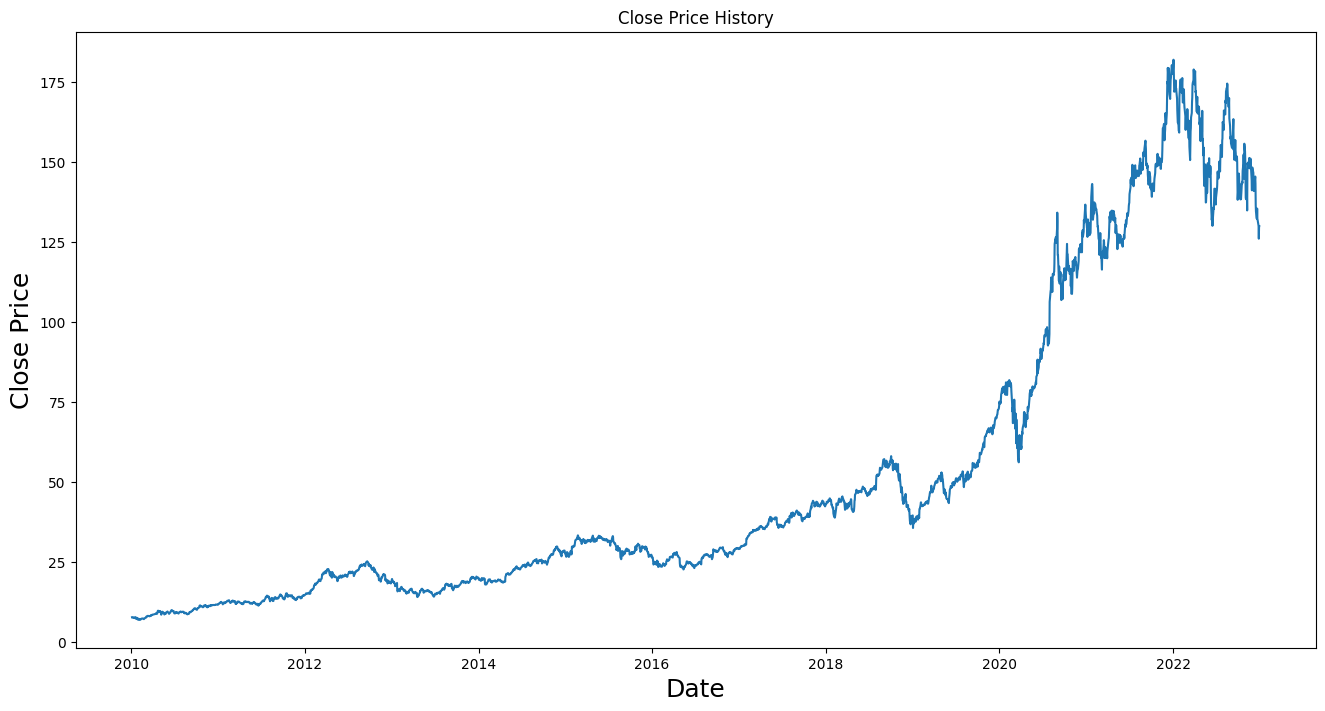

[array([4.47776362e-03, 4.55321042e-03, 3.85789270e-03, 3.77836496e-03,
       4.06383392e-03, 3.68253530e-03, 3.19519517e-03, 3.79263868e-03,
       3.54387631e-03, 2.83020666e-03, 4.68778577e-03, 4.01286179e-03,
       3.26656105e-03, 1.16225866e-03, 2.24703686e-03, 2.83224576e-03,
       3.22782354e-03, 1.47627233e-03, 2.03638039e-06, 5.46463221e-04,
       7.76876395e-04, 1.46403771e-03, 0.00000000e+00, 6.95312283e-04,
       4.22080672e-04, 8.44166789e-04, 6.25985509e-04, 1.34985068e-03,
       1.69853181e-03, 2.31432725e-03, 2.14100896e-03, 2.21848942e-03,
       1.96156791e-03, 1.70668550e-03, 1.02156329e-03, 1.75562669e-03,
       2.02885830e-03, 2.56308963e-03, 3.45416123e-03, 3.42561379e-03,
       3.52348256e-03, 3.80487330e-03, 5.48505863e-03, 5.51156697e-03,
       6.31495443e-03, 6.68606025e-03, 6.82063559e-03, 7.04493690e-03,
       6.48215813e-03, 6.60653796e-03, 6.53925029e-03, 6.64732002e-03,
       6.15794623e-03, 6.66771105e-03, 7.40380811e-03, 7.60975477e-03,
     

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3049/3049 ━━━━━━━━━━━━━━━━━━━━ 107s 34ms/step - loss: 0.0013


In [2]:
# Fetch the stock data using yfinance
stock_symbol = 'AAPL'  # Replace with the stock symbol you want to predict
df = yf.download(stock_symbol, start='2010-01-01', end='2023-01-01')
df.reset_index(inplace=True)

# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Date'], df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.show()

# Create a new dataframe with only the 'Close' column
data = df[['Close']]  # Correctly filter the 'Close' column
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * .95))

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i <= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

In [3]:
model.save('lstm_stock_model.h5')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [9]:
# Load the trained LSTM model
model = load_model("/content/lstm_stock_model.h5")

# Load the scaler
scaler = joblib.load('/content/scaler.pkl')

# Fetch the stock data using yfinance
stock_symbol = 'AAPL'  # Replace with the stock symbol you want to predict
df = yf.download(stock_symbol, start='2010-01-01', end='2023-01-01')
df.reset_index(inplace=True)

# Create a new dataframe with only the 'Close' column
data = df[['Close']]  # Correctly filter the 'Close' column

# Predict the next day's closing price
# Get the last 60 days of closing price values and scale the data
last_60_days = data[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

# Create an empty list and append the past 60 days
X_test = []
X_test.append(last_60_days_scaled)

# Convert the X_test data set to a numpy array
X_test = np.array(X_test)

# Reshape the data to be 3-D
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price
pred_price = model.predict(X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(f'Predicted next day closing price: {pred_price[0][0]}')

[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
Predicted next day closing price: 138.4420928955078
